In [9]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [13]:
import pandas as pd
df_main = pd.read_csv('/content/drive/MyDrive/Alex/TSE/Semester 4/Financial Econometrics/Nour homework 2 (Project)/2025-03.csv')
# remvoe first row
df_main = df_main.iloc[1:]
df = df_main.copy()
df_main.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
1,1/1/1959,2583.560,2426.0,15.188,276676.8154,18235.77392,21.9616,23.3868,22.2620,31.6664,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2593.596,2434.8,15.346,278713.9773,18369.56308,22.3917,23.7024,22.4549,31.8987,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2610.396,2452.7,15.491,277775.2539,18523.05762,22.7142,23.8459,22.5651,31.8987,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.0,12349.0,81.6405,NaN
4,4/1/1959,2627.446,2470.0,15.435,283362.7075,18534.46600,23.1981,24.1903,22.8957,32.4019,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.0,12484.0,81.8099,NaN
5,5/1/1959,2642.720,2486.4,15.622,285307.2201,18679.66354,23.5476,24.3911,23.1161,32.5567,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.0,12646.0,80.7315,NaN


# Simple Test analysis

Explained variance ratio: [0.52322685 0.17885345 0.07340986 0.05350315 0.03999508]
Forecasting RPI: RMSE = 1038.1702


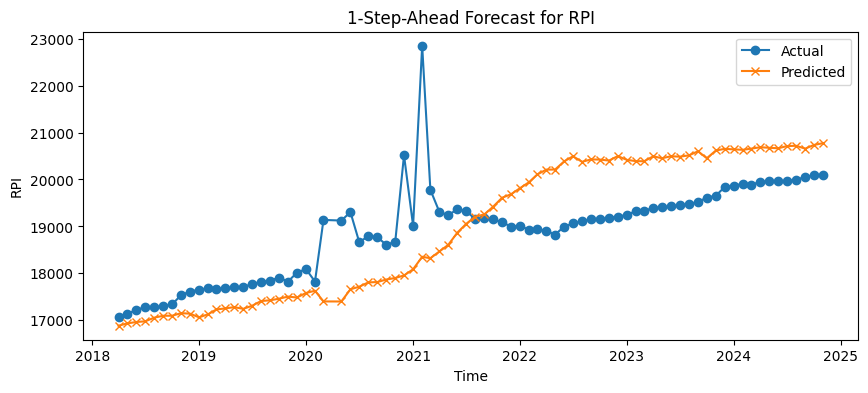

Forecasting INDPRO: RMSE = 5.0145


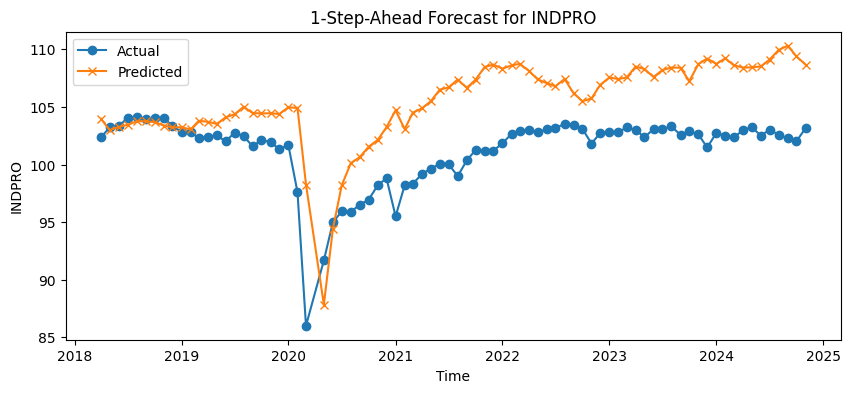

In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# ---------------------------
# 1. Data Preprocessing
# ---------------------------
df = df_main.copy()
df['sasdate'] = pd.to_datetime(df['sasdate'])
df = df.sort_values('sasdate').set_index('sasdate')
targets = ['RPI', 'INDPRO']
predictor_cols = [col for col in df.columns if col not in targets]
df = df.dropna(subset=predictor_cols)

# ---------------------------
# 2. Setting Up the Forecasting Problem
# ---------------------------
# We will forecast one period ahead (h = 1). To change the forecast horizon, set h accordingly.
h = 1

# Create lead versions of the target variables for h-step-ahead forecasting.
for target in targets:
    df[f'{target}_lead'] = df[target].shift(-h)

# Remove the final h rows which do not have a lead value
df = df.dropna(subset=[f'{target}_lead' for target in targets])

# ---------------------------
# 3. Factor Extraction via PCA (Diffusion Indexes)
# ---------------------------
# Standardize the predictors so that each series has zero mean and unit variance.
scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(df[predictor_cols])

# Choose the number of principal components (factors) to extract.
# You may experiment with this number (e.g., 2, 5, or more).
n_components = 5
pca = PCA(n_components=n_components)
# Extract the factors
factors = pca.fit_transform(predictors_scaled)

# For convenience, add the extracted factors as new columns in the DataFrame.
for i in range(n_components):
    df[f'Factor{i+1}'] = factors[:, i]

# You can inspect the explained variance ratio as a diagnostic.
print("Explained variance ratio:", pca.explained_variance_ratio_)

# ---------------------------
# 4. Direct Projection Forecasting using the PCA Factors
# ---------------------------
# The direct projection approach regresses the h-step ahead target on the factors (and optionally lagged values of the target).
# Here, we demonstrate a simple version that uses only the contemporaneous factors.

# We'll store results in a dictionary for each target.
forecast_results = {}

# Loop over each target variable.
for target in targets:
    target_lead = f'{target}_lead'

    # Use the factors as predictors for the direct projection regression.
    factor_cols = [f'Factor{i+1}' for i in range(n_components)]
    X = df[factor_cols]
    y = df[target_lead]

    # For illustration, split the dataset into training and testing sets (80% train, 20% test).
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx, :], X.iloc[split_idx:, :]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Fit a linear regression model (this is the direct projection estimation)
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Use the model to forecast on the test set.
    y_pred = model.predict(X_test)

    # Compute forecasting accuracy (using RMSE as an example)
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    forecast_results[target] = {
        'model': model,
        'rmse': rmse,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred
    }

    print(f'Forecasting {target}: RMSE = {rmse:.4f}')

    # Plot actual versus forecasted values for visual inspection.
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.index, y_test, label='Actual', marker='o')
    plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
    plt.title(f'1-Step-Ahead Forecast for {target}')
    plt.xlabel('Time')
    plt.ylabel(target)
    plt.legend()
    plt.show()

# Overview of Forecasting Model Implementation

This Colab notebook implements a comprehensive forecasting framework using a large panel of predictors. The primary targets are the macroeconomic variables **RPI** and **INDPRO**. The implementation follows a multi‐step process:

1. **Data Preprocessing:**  
   The dataset is first processed by converting the date column to a datetime format, sorting the observations by date, and setting the date as the index. Predictor variables (all series except the targets) are standardised using z–scores (via a `StandardScaler`), ensuring each series has zero mean and unit variance.

2. **Factor Selection:**  
   Two alternative approaches are employed to determine the optimal number of latent factors from the large panel of predictors:
   
   - **Bai and Ng (ICp2) Criterion:**  
     The code performs a singular value decomposition (SVD) on the standardised predictor matrix. For candidate factor numbers $r = 0, \ldots, r_{\text{max}}$, the residual sum of squares (SSR) not explained by the first $r$ factors is computed. The information criterion is defined as:  
     
     $$
     \text{ICp2}(r) = \ln\left(\frac{\mathrm{SSR}(r)}{N T}\right) + r \left(\frac{N+T}{N T}\right)\ln\left(\min\{N,T\}\right)
     $$

     where $N$ and $T$ denote the dimensions of the predictor matrix. The optimal number of factors is the value of $r$ that minimises the ICp2 value.
   
   - **Explained Variance Criterion:**  
     In parallel, a full principal component analysis (PCA) is conducted. The explained variance ratio for each principal component is computed and aggregated cumulatively. The optimal number of factors under this method is the smallest number that reaches or exceeds a preset cumulative explained variance threshold (e.g. 90%).

3. **Lag Order Selection for Forecast Regressions:**  
   To forecast the target variables, the framework employs a direct projection approach. Forecast regressions include:
   - The estimated PCA factors (available at time $t$).
   - A number of lags of the target variable (with the contemporaneous value considered as lag 0).
   
   The optimal lag length is chosen by comparing candidate models via information criteria. Two criteria are implemented:
   
   - **Bayesian Information Criterion (BIC):**  
     
     $$
     \mathrm{BIC} = T \ln\left(\frac{\mathrm{SSR}}{T}\right) + k \ln(T)
     $$

     where $\mathrm{SSR}$ is the sum of squared residuals, $k$ is the number of parameters (including the constant), and $T$ is the sample size.
   
   - **Hannan–Quinn Criterion (HQC):**  
     
     $$
     \mathrm{HQC} = T \ln\left(\frac{\mathrm{SSR}}{T}\right) + 2k \ln\left(\ln(T)\right)
     $$

   A dedicated function cycles over candidate lag orders (up to a specified maximum) and selects the lag length that optimises the chosen criterion (BIC or HQC).

4. **Multi-Horizon Forecasting:**  
   Forecasts are generated for three different horizons: 6, 12, and 24 periods ahead. For each forecast horizon:
   - Lead variables (i.e. $y_{t+h}$) are created for each target.
   - For each combination of factor–selection method (Bai and Ng vs. Explained Variance) and lag selection criterion (BIC vs. HQC), an OLS regression is estimated.  
   - The regression employs the contemporaneously available factors and the optimally selected lagged values of the target variable.
   - The forecasting performance is evaluated by computing the root mean squared error (RMSE) on a held-out test sample.

5. **Results Summary:**  
   All forecast results—including the chosen factor selection method, the number of factors used, the lag selection criterion, the forecast horizon, the target variable, the optimal lag order, and the corresponding RMSE—are recorded in a consolidated table. A pivot table is also generated to succinctly compare the different model specifications across targets and horizons.

This implementation provides a robust framework to compare alternative model specifications, facilitating an in-depth evaluation of how different information criteria and forecast horizons affect predictive accuracy.

## Code

Bai and Ng (ICp2) criterion values:
  r = 0, ICp2 = 0.0000
  r = 1, ICp2 = -0.6888
  r = 2, ICp2 = -1.1085
  r = 3, ICp2 = -1.3403
  r = 4, ICp2 = -1.5607
  r = 5, ICp2 = -1.7770
  r = 6, ICp2 = -1.9608
  r = 7, ICp2 = -2.1318
  r = 8, ICp2 = -2.2857
  r = 9, ICp2 = -2.4050
  r = 10, ICp2 = -2.5401

Optimal number of factors by Bai and Ng (ICp2): 10


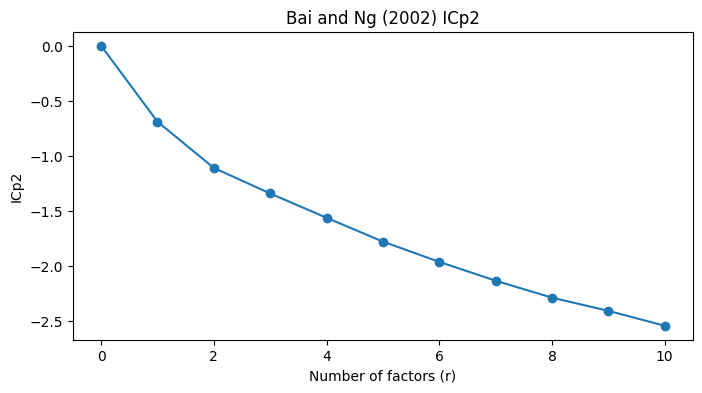

Factor 1: explained variance = 0.5228, cumulative = 0.5228
Factor 2: explained variance = 0.1792, cumulative = 0.7020
Factor 3: explained variance = 0.0734, cumulative = 0.7754
Factor 4: explained variance = 0.0534, cumulative = 0.8288
Factor 5: explained variance = 0.0402, cumulative = 0.8690
Factor 6: explained variance = 0.0274, cumulative = 0.8964
Factor 7: explained variance = 0.0206, cumulative = 0.9171
Factor 8: explained variance = 0.0154, cumulative = 0.9324
Factor 9: explained variance = 0.0106, cumulative = 0.9430
Factor 10: explained variance = 0.0097, cumulative = 0.9527


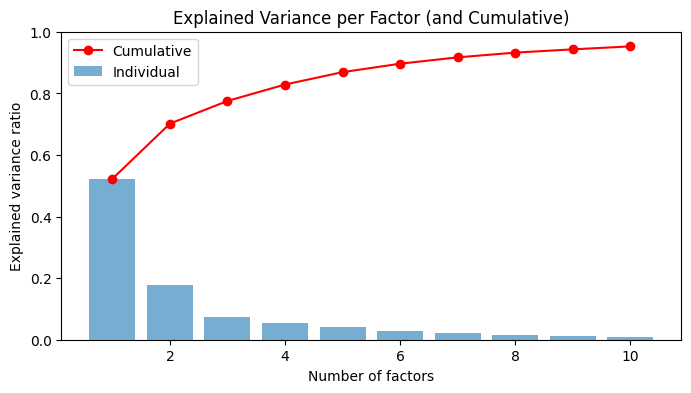


Explained Variance Criterion (>=90%) optimal number of factors: 7

====== Using BaiNg factor selection with 10 factors ======

-- Forecast horizon = 6 periods ahead; Lag criterion = BIC --

Forecasting RPI
Optimal lag order for RPI at horizon 6 (using BIC): 6 with BIC = 4410.1050
Forecast RMSE for RPI at horizon 6: 742.6565
Normalised RMSE for RPI at horizon 6: 0.0392


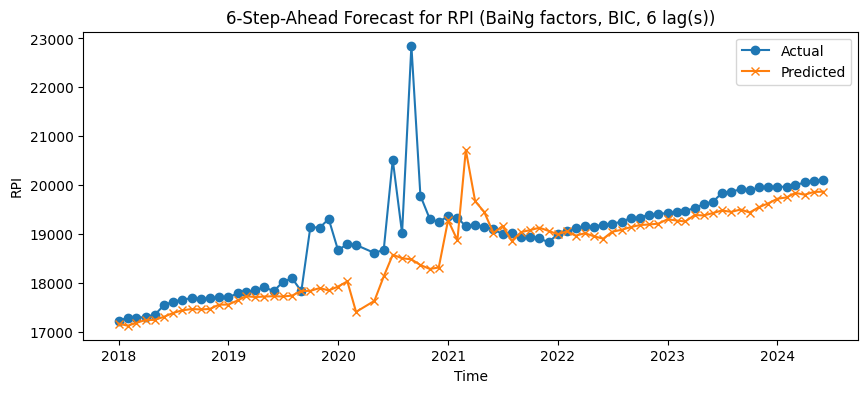


Forecasting INDPRO
Optimal lag order for INDPRO at horizon 6 (using BIC): 1 with BIC = 552.1464
Forecast RMSE for INDPRO at horizon 6: 3.8379
Normalised RMSE for INDPRO at horizon 6: 0.0379


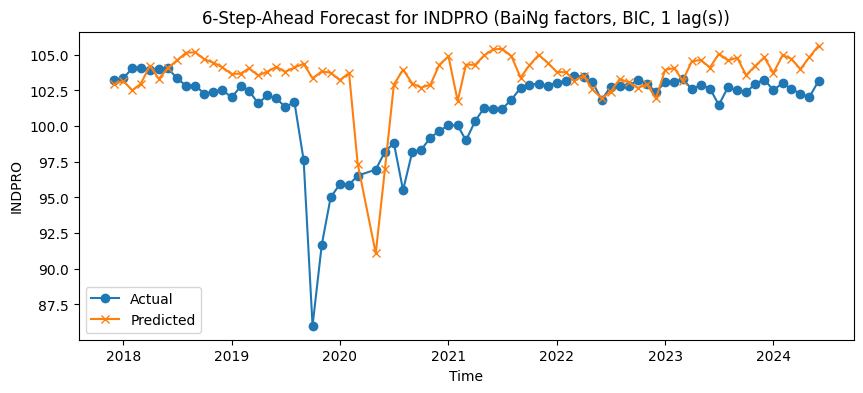


-- Forecast horizon = 12 periods ahead; Lag criterion = BIC --

Forecasting RPI
Optimal lag order for RPI at horizon 12 (using BIC): 6 with BIC = 4470.0961
Forecast RMSE for RPI at horizon 12: 873.9792
Normalised RMSE for RPI at horizon 12: 0.0461


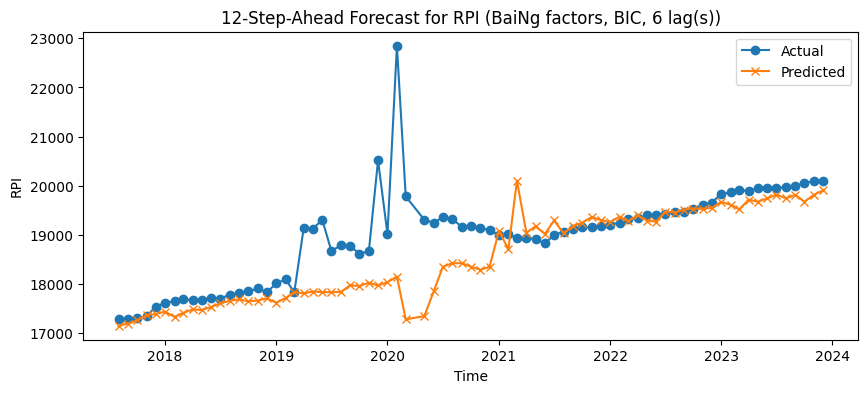


Forecasting INDPRO
Optimal lag order for INDPRO at horizon 12 (using BIC): 1 with BIC = 836.8370
Forecast RMSE for INDPRO at horizon 12: 14.3302
Normalised RMSE for INDPRO at horizon 12: 0.1415


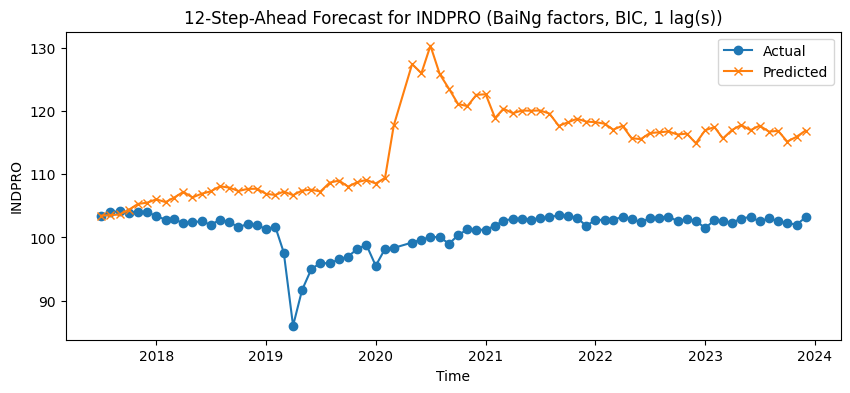


-- Forecast horizon = 24 periods ahead; Lag criterion = BIC --

Forecasting RPI
Optimal lag order for RPI at horizon 24 (using BIC): 6 with BIC = 4386.5144
Forecast RMSE for RPI at horizon 24: 1007.1503
Normalised RMSE for RPI at horizon 24: 0.0529


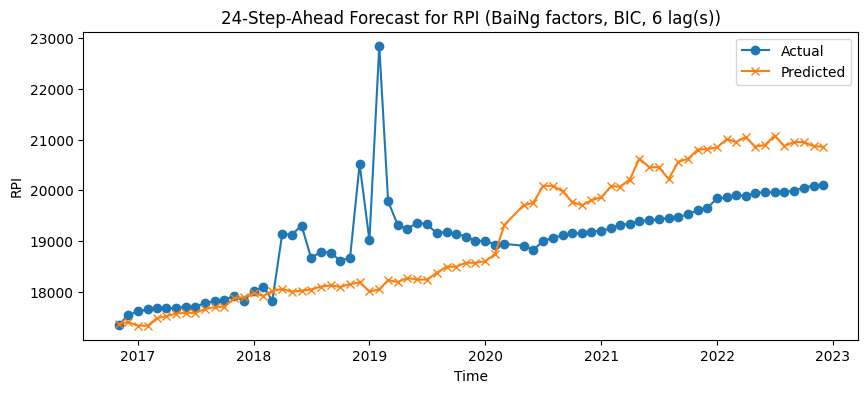


Forecasting INDPRO
Optimal lag order for INDPRO at horizon 24 (using BIC): 6 with BIC = 970.8586
Forecast RMSE for INDPRO at horizon 24: 30.8937
Normalised RMSE for INDPRO at horizon 24: 0.3054


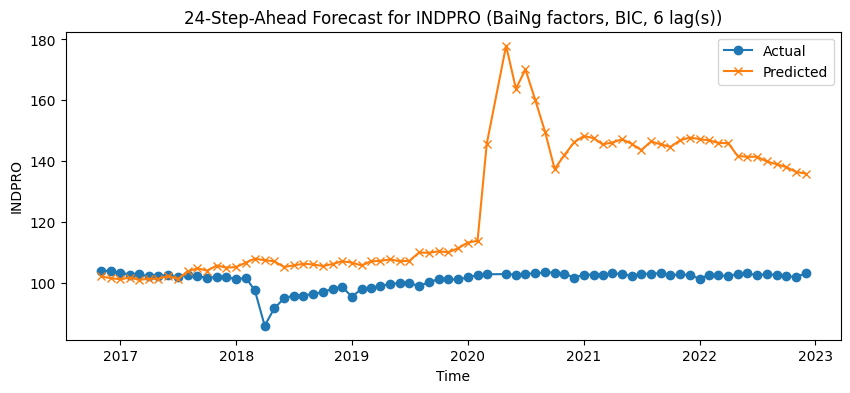


-- Forecast horizon = 6 periods ahead; Lag criterion = HQC --

Forecasting RPI
Optimal lag order for RPI at horizon 6 (using HQC): 6 with HQC = 4369.6125
Forecast RMSE for RPI at horizon 6: 742.6565
Normalised RMSE for RPI at horizon 6: 0.0392


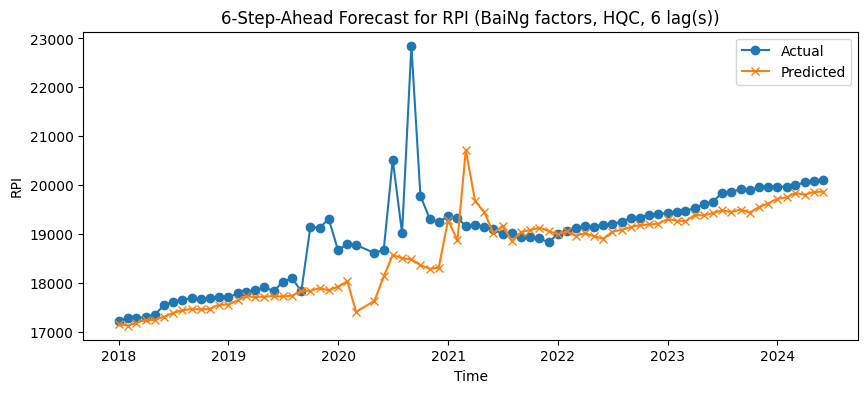


Forecasting INDPRO
Optimal lag order for INDPRO at horizon 6 (using HQC): 4 with HQC = 521.2634
Forecast RMSE for INDPRO at horizon 6: 4.1684
Normalised RMSE for INDPRO at horizon 6: 0.0412


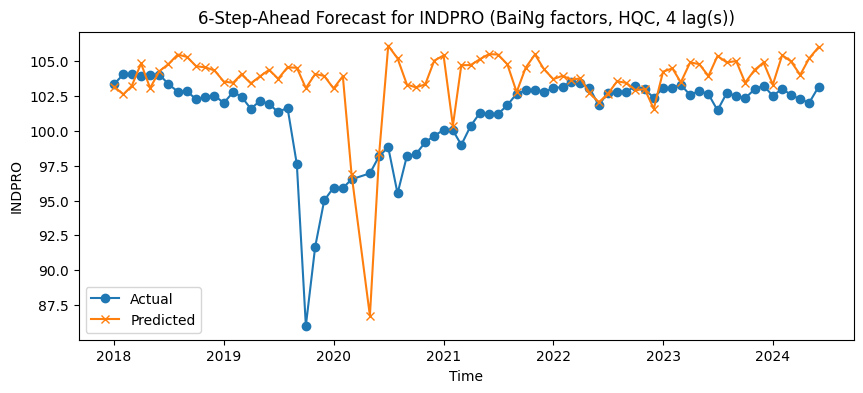


-- Forecast horizon = 12 periods ahead; Lag criterion = HQC --

Forecasting RPI
Optimal lag order for RPI at horizon 12 (using HQC): 6 with HQC = 4429.7816
Forecast RMSE for RPI at horizon 12: 873.9792
Normalised RMSE for RPI at horizon 12: 0.0461


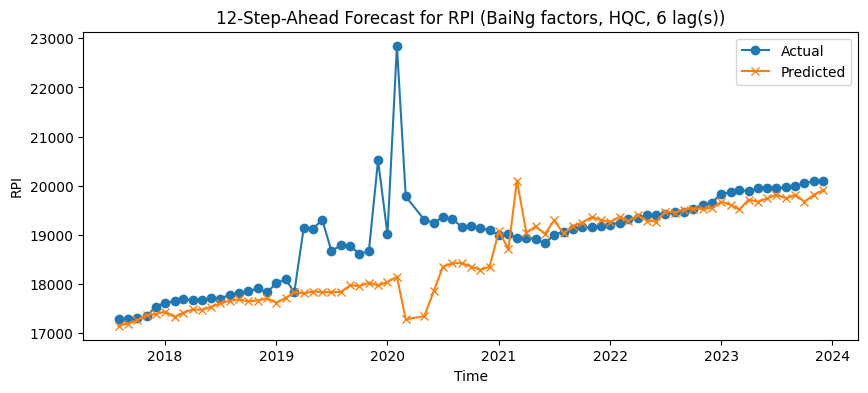


Forecasting INDPRO
Optimal lag order for INDPRO at horizon 12 (using HQC): 3 with HQC = 804.9413
Forecast RMSE for INDPRO at horizon 12: 14.4845
Normalised RMSE for INDPRO at horizon 12: 0.1430


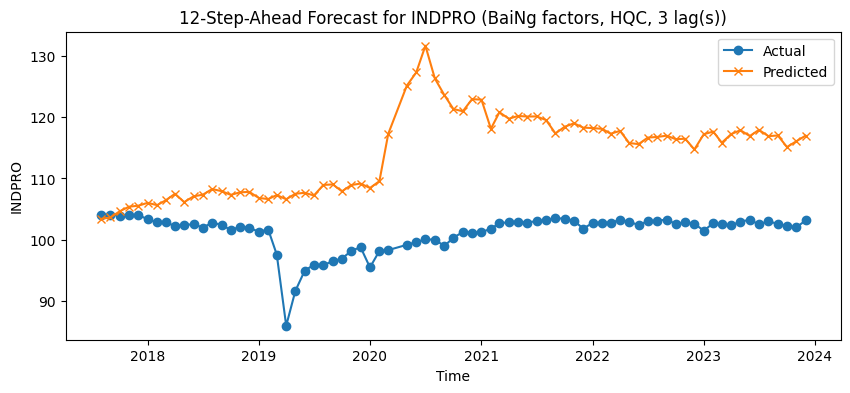


-- Forecast horizon = 24 periods ahead; Lag criterion = HQC --

Forecasting RPI
Optimal lag order for RPI at horizon 24 (using HQC): 6 with HQC = 4346.5639
Forecast RMSE for RPI at horizon 24: 1007.1503
Normalised RMSE for RPI at horizon 24: 0.0529


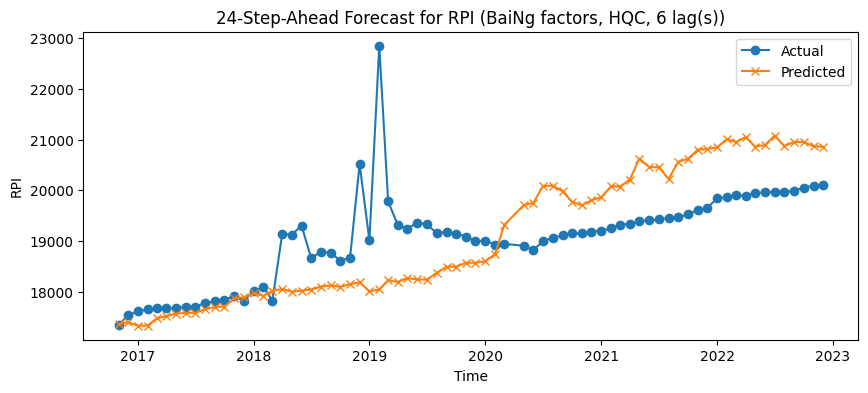


Forecasting INDPRO
Optimal lag order for INDPRO at horizon 24 (using HQC): 6 with HQC = 930.9081
Forecast RMSE for INDPRO at horizon 24: 30.8937
Normalised RMSE for INDPRO at horizon 24: 0.3054


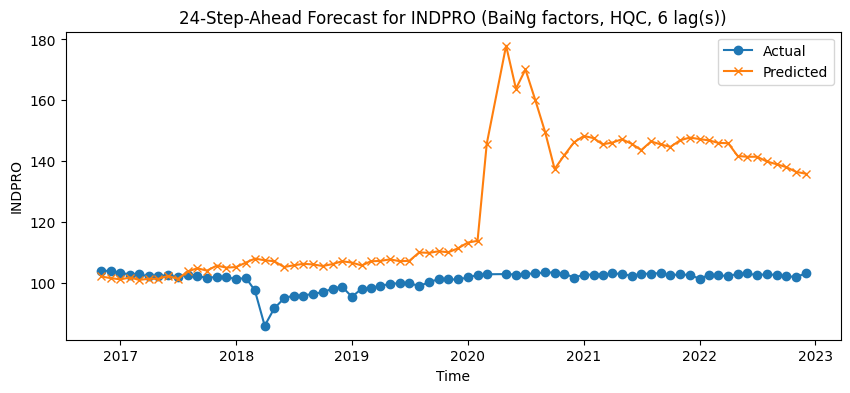


====== Using ExplVar factor selection with 7 factors ======

-- Forecast horizon = 6 periods ahead; Lag criterion = BIC --

Forecasting RPI
Optimal lag order for RPI at horizon 6 (using BIC): 6 with BIC = 4480.0474
Forecast RMSE for RPI at horizon 6: 692.6793
Normalised RMSE for RPI at horizon 6: 0.0366


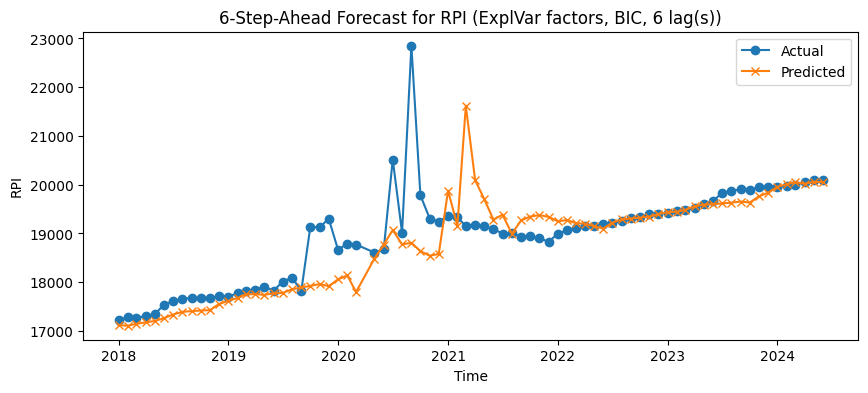


Forecasting INDPRO
Optimal lag order for INDPRO at horizon 6 (using BIC): 1 with BIC = 586.0140
Forecast RMSE for INDPRO at horizon 6: 5.1207
Normalised RMSE for INDPRO at horizon 6: 0.0505


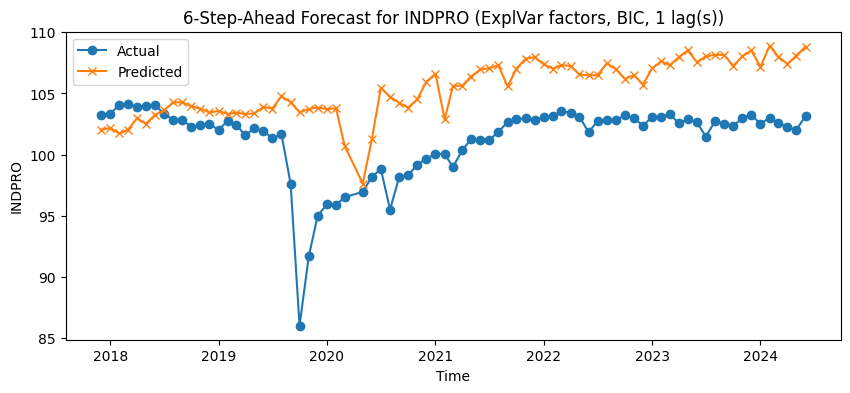


-- Forecast horizon = 12 periods ahead; Lag criterion = BIC --

Forecasting RPI
Optimal lag order for RPI at horizon 12 (using BIC): 6 with BIC = 4578.5530
Forecast RMSE for RPI at horizon 12: 856.9786
Normalised RMSE for RPI at horizon 12: 0.0452


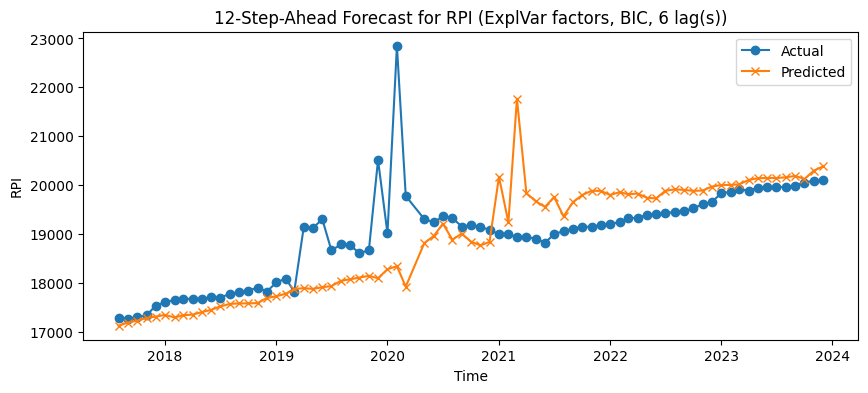


Forecasting INDPRO
Optimal lag order for INDPRO at horizon 12 (using BIC): 1 with BIC = 881.3223
Forecast RMSE for INDPRO at horizon 12: 10.2998
Normalised RMSE for INDPRO at horizon 12: 0.1017


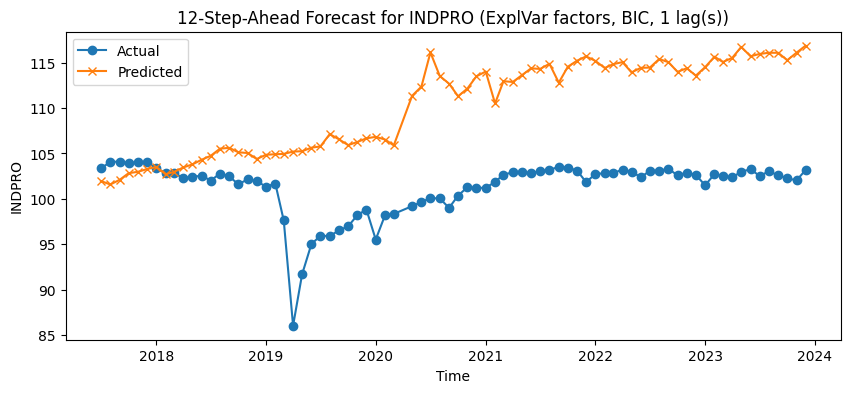


-- Forecast horizon = 24 periods ahead; Lag criterion = BIC --

Forecasting RPI
Optimal lag order for RPI at horizon 24 (using BIC): 6 with BIC = 4490.1752
Forecast RMSE for RPI at horizon 24: 944.0456
Normalised RMSE for RPI at horizon 24: 0.0496


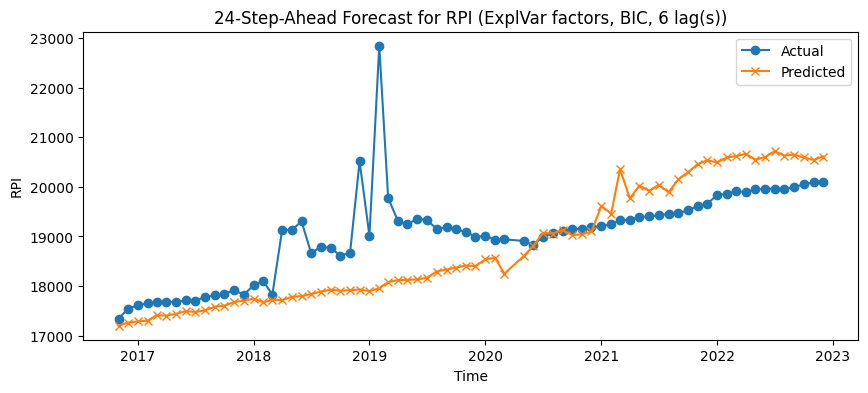


Forecasting INDPRO
Optimal lag order for INDPRO at horizon 24 (using BIC): 2 with BIC = 1004.2797
Forecast RMSE for INDPRO at horizon 24: 7.6573
Normalised RMSE for INDPRO at horizon 24: 0.0757


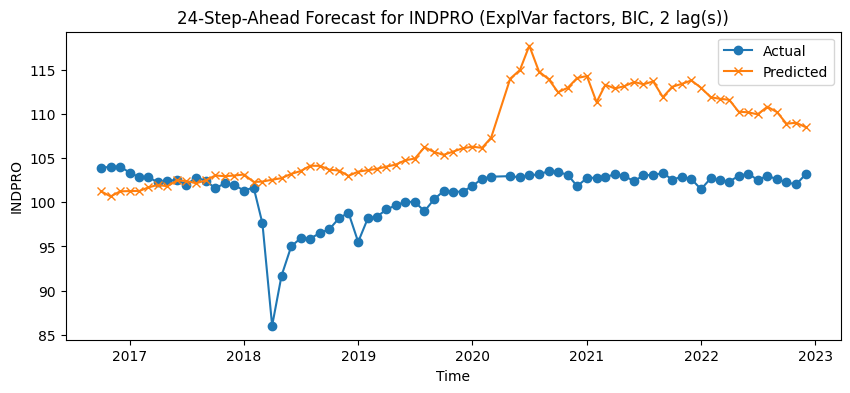


-- Forecast horizon = 6 periods ahead; Lag criterion = HQC --

Forecasting RPI
Optimal lag order for RPI at horizon 6 (using HQC): 6 with HQC = 4446.7006
Forecast RMSE for RPI at horizon 6: 692.6793
Normalised RMSE for RPI at horizon 6: 0.0366


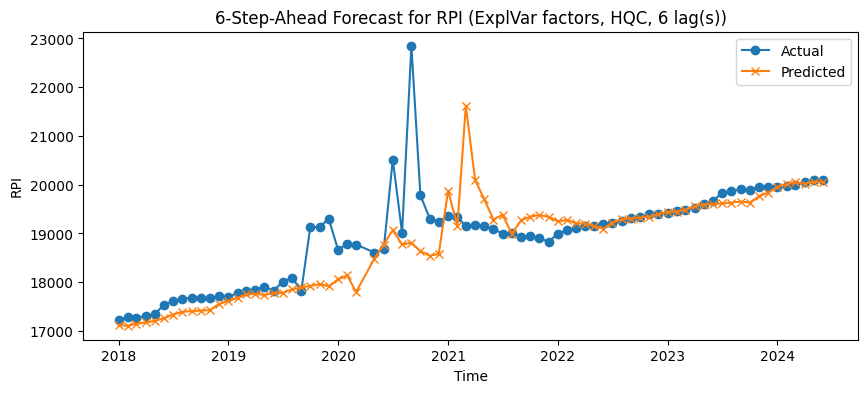


Forecasting INDPRO
Optimal lag order for INDPRO at horizon 6 (using HQC): 1 with HQC = 564.4992
Forecast RMSE for INDPRO at horizon 6: 5.1207
Normalised RMSE for INDPRO at horizon 6: 0.0505


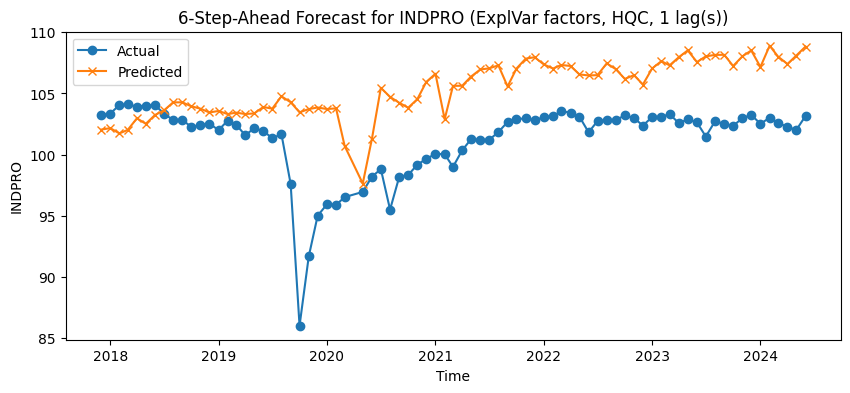


-- Forecast horizon = 12 periods ahead; Lag criterion = HQC --

Forecasting RPI
Optimal lag order for RPI at horizon 12 (using HQC): 6 with HQC = 4545.3528
Forecast RMSE for RPI at horizon 12: 856.9786
Normalised RMSE for RPI at horizon 12: 0.0452


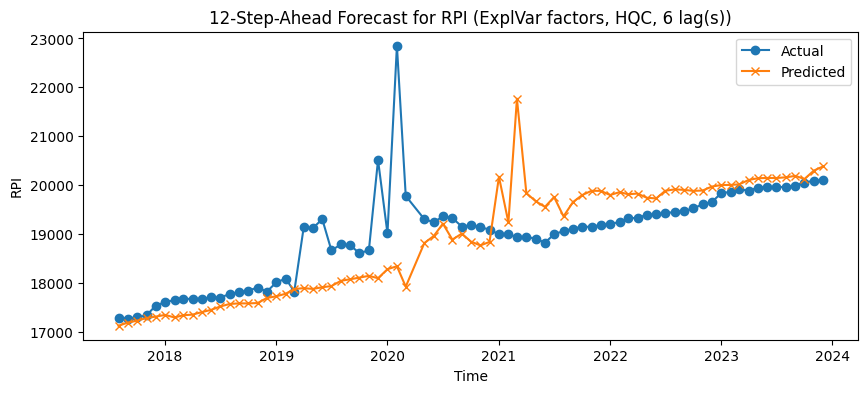


Forecasting INDPRO
Optimal lag order for INDPRO at horizon 12 (using HQC): 6 with HQC = 857.3551
Forecast RMSE for INDPRO at horizon 12: 12.4099
Normalised RMSE for INDPRO at horizon 12: 0.1226


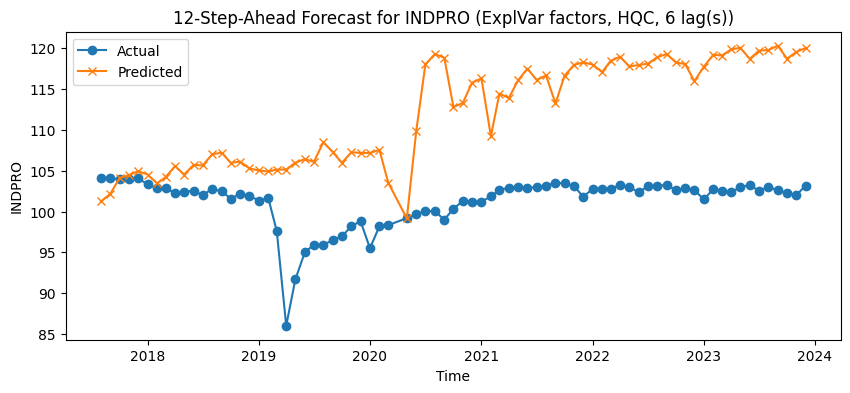


-- Forecast horizon = 24 periods ahead; Lag criterion = HQC --

Forecasting RPI
Optimal lag order for RPI at horizon 24 (using HQC): 6 with HQC = 4457.2748
Forecast RMSE for RPI at horizon 24: 944.0456
Normalised RMSE for RPI at horizon 24: 0.0496


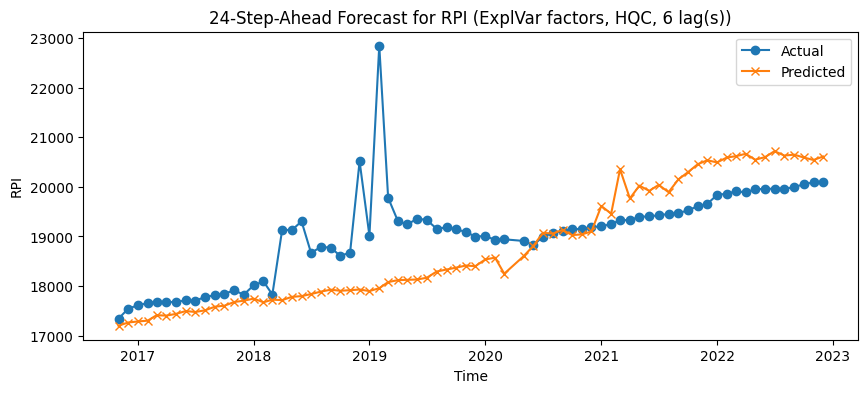


Forecasting INDPRO
Optimal lag order for INDPRO at horizon 24 (using HQC): 6 with HQC = 974.4221
Forecast RMSE for INDPRO at horizon 24: 8.4529
Normalised RMSE for INDPRO at horizon 24: 0.0836


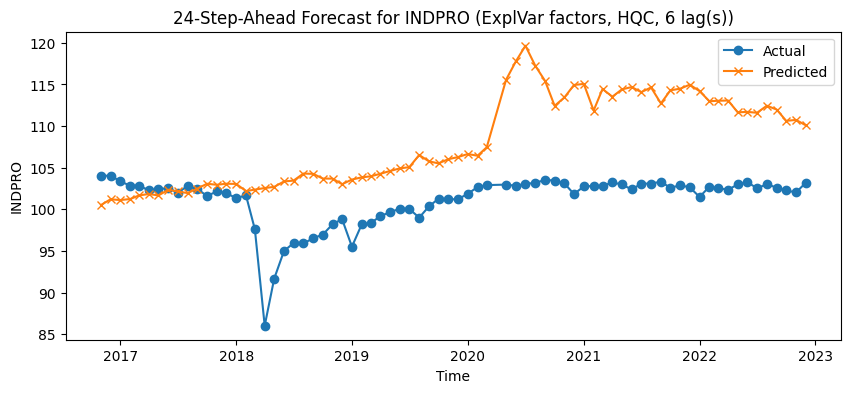


Summary of Forecast Results (including Normalised RMSE):
   FactorMethod  NumFactors LagCriterion  Horizon  Target  OptimalLag  \
1         BaiNg          10          BIC        6  INDPRO           1   
7         BaiNg          10          HQC        6  INDPRO           4   
13      ExplVar           7          BIC        6  INDPRO           1   
19      ExplVar           7          HQC        6  INDPRO           1   
3         BaiNg          10          BIC       12  INDPRO           1   
9         BaiNg          10          HQC       12  INDPRO           3   
15      ExplVar           7          BIC       12  INDPRO           1   
21      ExplVar           7          HQC       12  INDPRO           6   
5         BaiNg          10          BIC       24  INDPRO           6   
11        BaiNg          10          HQC       24  INDPRO           6   
17      ExplVar           7          BIC       24  INDPRO           2   
23      ExplVar           7          HQC       24  INDPRO         

In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ===============================
# PRELIMINARY: Data Preprocessing
# ===============================
# Assume df_main is your main DataFrame.
df = df_main.copy()
df['sasdate'] = pd.to_datetime(df['sasdate'])
df = df.sort_values('sasdate').set_index('sasdate')
targets = ['RPI', 'INDPRO']
predictor_cols = [col for col in df.columns if col not in targets]
df = df.dropna(subset=predictor_cols)

# Instantiate a scaler.
scaler = StandardScaler()

# Standardize predictors.
predictors_scaled = scaler.fit_transform(df[predictor_cols])

# ===============================
# PART 1: Factor Selection – Bai and Ng (ICp2)
# ===============================
def compute_bai_ng_ic(X, r_max):
    """
    Compute the Bai and Ng ICp2 for candidate factor numbers r = 0,...,r_max.
    """
    T, N = X.shape
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    s_squared = s**2
    ic_values = []
    for r in range(r_max + 1):
        SSR = np.sum(s_squared[r:])  # SSR not captured by the first r factors
        V_r = SSR / (N * T)          # average squared residual
        penalty = r * ((N + T) / (N * T)) * np.log(min(N, T))
        ic = np.log(V_r) + penalty
        ic_values.append(ic)
    return ic_values

# Set candidate maximum factors.
r_max = 10
ic_values = compute_bai_ng_ic(predictors_scaled, r_max)
print("Bai and Ng (ICp2) criterion values:")
for r, ic in enumerate(ic_values):
    print(f"  r = {r}, ICp2 = {ic:.4f}")
optimal_r_BN = np.argmin(ic_values)
print("\nOptimal number of factors by Bai and Ng (ICp2):", optimal_r_BN)

plt.figure(figsize=(8,4))
plt.plot(range(r_max+1), ic_values, marker='o')
plt.xlabel("Number of factors (r)")
plt.ylabel("ICp2")
plt.title("Bai and Ng (2002) ICp2")
plt.show()

# ===============================
# PART 2: Factor Selection – Explained Variance Criterion
# ===============================
pca_full = PCA(n_components=r_max)
pca_full.fit(predictors_scaled)
explained = pca_full.explained_variance_ratio_
cumulative_explained = np.cumsum(explained)
for i, (exp, cum) in enumerate(zip(explained, cumulative_explained)):
    print(f"Factor {i+1}: explained variance = {exp:.4f}, cumulative = {cum:.4f}")
plt.figure(figsize=(8,4))
plt.bar(range(1, r_max+1), explained, alpha=0.6, label='Individual')
plt.plot(range(1, r_max+1), cumulative_explained, marker='o', color='red', label='Cumulative')
plt.xlabel("Number of factors")
plt.ylabel("Explained variance ratio")
plt.title("Explained Variance per Factor (and Cumulative)")
plt.legend()
plt.show()

variance_threshold = 0.90  # e.g., 90% threshold
optimal_r_VAR = np.where(cumulative_explained >= variance_threshold)[0][0] + 1
print("\nExplained Variance Criterion (>=90%) optimal number of factors:", optimal_r_VAR)

# ===============================
# PART 3: Forecasting Setup and Extended Lag Selection Function
# ===============================
def select_optimal_lags(y_dep, y_current, X, max_lag=6, criterion='BIC'):
    """
    Select the optimal number of lags (p) for the forecast regression using either BIC or HQC.

    The regression model uses:
      - Dependent variable: y_dep (e.g., y_{t+h})
      - Explanatory variables: The PCA factors (X, at time t) plus p lags of y_current (with lag0 = y_t)

    Parameters:
      y_dep    : pd.Series, the h-step-ahead dependent variable.
      y_current: pd.Series, the current value of the target variable.
      X        : pd.DataFrame, the factor predictors.
      max_lag  : maximum number of lags to consider.
      criterion: 'BIC' or 'HQC'.

    Returns:
      best_p     : optimal lag order.
      best_ic    : the IC value (BIC or HQC) at the optimum.
      best_model : the fitted OLS model.
      design_df  : the design DataFrame used.
    """
    import warnings
    warnings.filterwarnings("ignore")

    ic_values = []
    models = []
    design_matrices = []
    base_df = pd.concat([y_dep, X], axis=1).rename(columns={y_dep.name: "y_dep"})
    candidate_ls = list(range(max_lag+1))
    for p in candidate_ls:
        df_model = base_df.copy()
        for j in range(p):
            df_model[f'y_lag{j+1}'] = y_current.shift(j)
        df_model = df_model.dropna()
        if df_model.empty:
            ic_values.append(np.inf)
            models.append(None)
            design_matrices.append(None)
            continue
        y_reg = df_model['y_dep']
        X_reg = df_model.drop(columns='y_dep')
        X_reg = sm.add_constant(X_reg)
        model = sm.OLS(y_reg, X_reg).fit()
        SSR = np.sum(model.resid ** 2)
        k = X_reg.shape[1]
        T_reg = len(y_reg)
        if criterion == 'BIC':
            ic = T_reg * np.log(SSR/T_reg) + k * np.log(T_reg)
        elif criterion == 'HQC':
            ic = T_reg * np.log(SSR/T_reg) + 2 * k * np.log(np.log(T_reg))
        else:
            raise ValueError("criterion must be 'BIC' or 'HQC'")
        ic_values.append(ic)
        models.append(model)
        design_matrices.append(df_model)

    best_index = np.argmin(ic_values)
    best_p = candidate_ls[best_index]
    best_ic = ic_values[best_index]
    return best_p, best_ic, models[best_index], design_matrices[best_index]

# ===============================
# PART 4: Multi-Horizon Forecasting and Model Comparisons
# ===============================
# Forecast horizons (in periods)
horizons = [6, 12, 24]

# We'll store forecast results in a list for later summary.
results_list = []

# Loop over factor selection methods.
for factor_method_label, optimal_r_method in [("BaiNg", optimal_r_BN), ("ExplVar", optimal_r_VAR)]:
    print(f"\n====== Using {factor_method_label} factor selection with {optimal_r_method} factors ======")
    predictors_scaled = scaler.fit_transform(df[predictor_cols])
    pca_method = PCA(n_components=optimal_r_method)
    factors_method = pca_method.fit_transform(predictors_scaled)
    df_with_factors = df.copy()
    for i in range(optimal_r_method):
        df_with_factors.loc[:, f'Factor{i+1}'] = factors_method[:, i]
    factor_cols_method = [f'Factor{i+1}' for i in range(optimal_r_method)]

    # Loop over lag selection criteria.
    for lag_criterion in ["BIC", "HQC"]:
        # Loop over forecast horizons.
        for h in horizons:
            print(f"\n-- Forecast horizon = {h} periods ahead; Lag criterion = {lag_criterion} --")
            df_h = df_with_factors.copy()
            for target in targets:
                df_h[f'{target}_lead'] = df_h[target].shift(-h)
            df_h = df_h.dropna(subset=[f'{target}_lead' for target in targets]).copy()

            for target in targets:
                print(f"\nForecasting {target}")
                y_dep = df_h[f'{target}_lead']
                y_current = df_h[target]
                X_factors = df_h[factor_cols_method]

                best_p, best_ic, best_model, design_df = select_optimal_lags(
                    y_dep, y_current, X_factors, max_lag=6, criterion=lag_criterion)
                print(f'Optimal lag order for {target} at horizon {h} (using {lag_criterion}): {best_p} with {lag_criterion} = {best_ic:.4f}')

                split_index = int(len(design_df) * 0.8)
                y_all = design_df['y_dep']
                X_all = design_df.drop(columns='y_dep')
                X_all = sm.add_constant(X_all, has_constant='add')
                X_train = X_all.iloc[:split_index, :]
                X_test  = X_all.iloc[split_index:, :]
                y_train = y_all.iloc[:split_index]
                y_test  = y_all.iloc[split_index:]

                final_model = sm.OLS(y_train, X_train).fit()
                y_pred = final_model.predict(X_test)
                rmse = np.sqrt(np.mean((y_test - y_pred)**2))
                # Compute the normalised RMSE by dividing the RMSE by the mean of the actual values.
                norm_rmse = rmse / np.mean(y_test)
                print(f'Forecast RMSE for {target} at horizon {h}: {rmse:.4f}')
                print(f'Normalised RMSE for {target} at horizon {h}: {norm_rmse:.4f}')

                # Store the results.
                results_list.append({
                    'FactorMethod': factor_method_label,
                    'NumFactors': optimal_r_method,
                    'LagCriterion': lag_criterion,
                    'Horizon': h,
                    'Target': target,
                    'OptimalLag': best_p,
                    'IC_Value': best_ic,
                    'RMSE': rmse,
                    'Norm_RMSE': norm_rmse
                })

                plt.figure(figsize=(10, 4))
                plt.plot(y_test.index, y_test, label='Actual', marker='o')
                plt.plot(y_test.index, y_pred, label='Predicted', marker='x')
                plt.title(f'{h}-Step-Ahead Forecast for {target} ({factor_method_label} factors, {lag_criterion}, {best_p} lag(s))')
                plt.xlabel('Time')
                plt.ylabel(target)
                plt.legend()
                plt.show()

# ===============================
# PART 5: Summarize All RMSE in a Comparison Table
# ===============================
results_df = pd.DataFrame(results_list)
print("\nSummary of Forecast Results (including Normalised RMSE):")
print(results_df.sort_values(by=['Target', 'Horizon', 'FactorMethod', 'LagCriterion']))

# Optionally, pivot the table for a more compact display.
pivot_table = results_df.pivot_table(
    index=['Target', 'Horizon'],
    columns=['FactorMethod', 'LagCriterion'],
    values=['OptimalLag', 'RMSE', 'Norm_RMSE'],
    aggfunc='first'
)
print("\nPivot Table Summary (OptimalLag, RMSE and Normalised RMSE):")
print(pivot_table)

## Summary Table

| Target | Horizon | BaiNg-BIC (Lag) | BaiNg-BIC (RMSE) | BaiNg-BIC (Norm RMSE) | BaiNg-HQC (Lag) | BaiNg-HQC (RMSE) | BaiNg-HQC (Norm RMSE) | ExplVar-BIC (Lag) | ExplVar-BIC (RMSE) | ExplVar-BIC (Norm RMSE) | ExplVar-HQC (RMSE) | ExplVar-HQC (Norm RMSE) |
|--------|---------|------------------|-------------------|------------------------|------------------|-------------------|------------------------|--------------------|---------------------|--------------------------|---------------------|--------------------------|
| INDPRO | 6       | 1                | 3.837905          | 0.037882               | 4                | 4.168392          | 0.041154               | 1                  | 5.120680            | 0.050544                 | 5.120680            | 0.050544                 |
|        | 12      | 1                | 14.330164         | 0.141481               | 3                | 14.484451         | 0.143043               | 1                  | 10.299763           | 0.101689                 | 12.409947           | 0.122556                 |
|        | 24      | 6                | 30.893699         | 0.305438               | 6                | 30.893699         | 0.305438               | 2                  | 7.657332            | 0.075678                 | 8.452899            | 0.083572                 |
| RPI    | 6       | 6                | 742.656549        | 0.039201               | 6                | 742.656549        | 0.039201               | 6                  | 692.679311          | 0.036563                 | 692.679311          | 0.036563                 |
|        | 12      | 6                | 873.979225        | 0.046078               | 6                | 873.979225        | 0.046078               | 6                  | 856.978597          | 0.045181                 | 856.978597          | 0.045181                 |
|        | 24      | 6                | 1007.150257       | 0.052906               | 6                | 1007.150257       | 0.052906               | 6                  | 944.045644          | 0.049591                 | 944.045644          | 0.049591                 |

# Extension